# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import glob

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
ROOMS_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_rooms.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(ROOMS_MODEL_PATH):
    utils.download_trained_weights(ROOMS_MODEL_PATH)

## Configurations

In [3]:
class RoomsConfig(Config):
    NAME = "objects"
    IMAGES_PER_GPU=1
    NUM_CLASSES = 4 #floor, structure, prop, furniture
    IMAGE_MIN_DIM = 480
    IMAGE_MAX_DIM = 640
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = RoomsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  480
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
    name = "testing"    
    DIR = os.path.join("/data", name)
    #DIR =os.path.join(ROOT_DIR, "NYU_DIRECTORY/"+name)
    #DIR=os.path.join(DIR, "**/*colors.png")
    DIR

'/data/testing'

In [6]:
class RoomsDataset(utils.Dataset):
    def load_rooms(self, name, height, width):
                # Add classes
        self.add_class("objects", 1, "floor")#(7, 54, 66)
        self.add_class("objects",2 , "structure")#(147, 161, 161)
        self.add_class("objects", 3, "prop")#(181, 137, 0)
        self.add_class("objects", 4,"furniture")#(203, 75, 22)
        #DIR1 =os.path.join(ROOT_DIR, "NYU_DIRECTORY/"+name)
        DIR1 = os.path.join("/data", name)
        DIR=os.path.join(DIR1, "**/*colors.png")
        print(DIR)
        for file in glob.glob(DIR, recursive = True):
            head, tail = os.path.split(file)
            #self.add_image(source = ['floor', 'structure', 'prop', 'furniture'] ,image_id = tail[:5], path = file, height = height, width=width)
            self.add_image(source = 'objects' ,image_id = tail[:5], path = file, height = height, width=width)
     
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "objects":
            return info["objects"]
        else:
            super(self.__class__).image_reference(self, image_id)
            
    def load_mask(self, image_id):
        DIR = "/data"
        info = self.image_info[image_id]
        objects = info['source']
        print(info)
        image_name="{}{}"
        image_name = image_name.format(info['id'], "_ground_truth.png")
        mask_source = find(image_name, DIR)
        mask_image = cv2.imread(mask_source)
        print(mask_source)
        mask = np.zeros([info['height'], info['width'], 4], dtype=np.uint8)
        for i in range(480):
            for j in range(640):
                pixel = mask_image[i,j]
                p = (pixel[0], pixel[1], pixel[2])

                #     (7, 54, 66),  # floor
                if p == (66, 54, 7): # pixel[0]== 66 and pixel[1] == 54 and pixel[2] == 7:
                    mask[i][j][0] = 0b00000001
                #    (147, 161, 161),  # structure
                elif pixel[0] == 161 and pixel[1]==161 and pixel[2] == 147:
                    mask[i][j][1] = 0b00000010
                        #(181, 137, 0),  # prop
                elif pixel[0] ==0 and pixel[1] == 137 and pixel[2] ==181:
                    mask[i][j][2] = 0b00000100
                    #    (203, 75, 22),  # furniture
                elif pixel[0]==22 and pixel[1] ==75 and pixel[2]==203:
                    mask[i][j][3] = 0b00001000
                    
        class_ids = np.array([1,2,3,4])
        return mask.astype(np.bool), class_ids.astype(np.int32)

def find(name, path):
    print(name, path)
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)


In [7]:
class_names = ['floor', 'structure', 'prop', 'furniture']

In [8]:

dataset_train =RoomsDataset()
dataset_train.load_rooms("training", 480, 640)
dataset_train.prepare()

dataset_val = RoomsDataset()
dataset_val.load_rooms("testing", 480, 640)
dataset_val.prepare()

/data/training/**/*colors.png
/data/testing/**/*colors.png


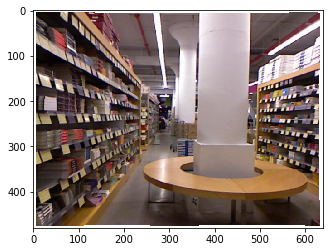

In [9]:
plt.imshow(dataset_train.load_image(4))

{'width': 640, 'height': 480, 'source': 'objects', 'id': '00399', 'path': '/data/training/all_train_pairs/00399_colors.png'}
00399_ground_truth.png /data
/data/training/all_train_pairs/00399_ground_truth.png


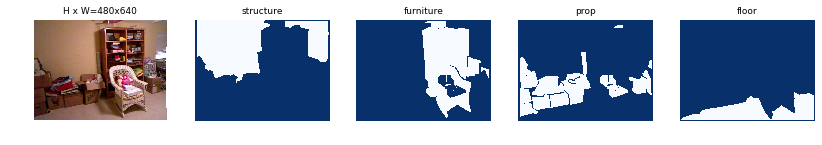

{'width': 640, 'height': 480, 'source': 'objects', 'id': '01189', 'path': '/data/training/all_train_pairs/01189_colors.png'}
01189_ground_truth.png /data
/data/training/all_train_pairs/01189_ground_truth.png


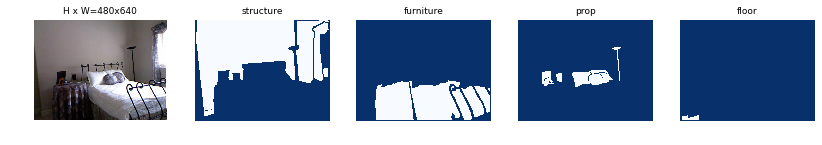

{'width': 640, 'height': 480, 'source': 'objects', 'id': '00909', 'path': '/data/training/all_train_pairs/00909_colors.png'}
00909_ground_truth.png /data
/data/training/all_train_pairs/00909_ground_truth.png


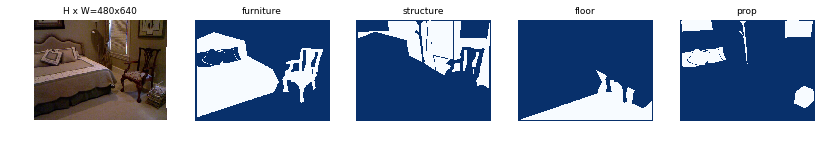

{'width': 640, 'height': 480, 'source': 'objects', 'id': '00543', 'path': '/data/training/all_train_pairs/00543_colors.png'}
00543_ground_truth.png /data
/data/training/all_train_pairs/00543_ground_truth.png


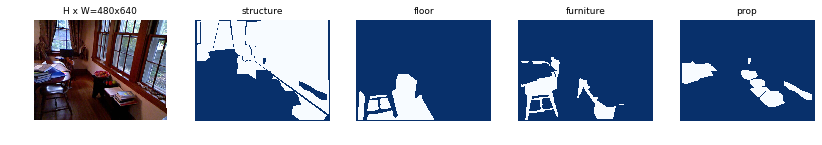

In [10]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [12]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(ROOMS_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [14]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/camila_vasquez/not-corners-anymore/Mask_RCNN-master/logs/objects20190416T2011/mask_rcnn_objects_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_co

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00602', 'path': '/data/testing/all_test_pairs/00602_colors.png'}
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00912', 'path': '/data/training/all_train_pairs/00912_colors.png'}
00602_ground_truth.png /data
00912_ground_truth.png /data
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00602', 'path': '/data/testing/all_test_pairs/00602_colors.png'}
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00602', 'path': '/data/testing/all_test_pairs/00602_colors.png'}
00602_ground_truth.png /data
/data/training/all_train_pairs/00912_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00602', 'path': '/data/testing/all_test_pairs/00602_colors.png'}
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00912', 'path': '/data/training/all_train_pairs/00912_colors.png'}
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00912', 'path': '/data/training/all_train_pairs/0

ValueError: Error when checking input: expected input_image_meta to have shape (16,) but got array with shape (17,)

{'width': 640, 'height': 480, 'source': 'objects', 'id': '00530', 'path': '/data/testing/all_test_pairs/00530_colors.png'}
00530_ground_truth.png /data
/data/testing/all_test_pairs/00530_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00530', 'path': '/data/testing/all_test_pairs/00530_colors.png'}
00530_ground_truth.png /data
/data/testing/all_test_pairs/00530_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00530', 'path': '/data/testing/all_test_pairs/00530_colors.png'}
00530_ground_truth.png /data
/data/testing/all_test_pairs/00530_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00348', 'path': '/data/training/all_train_pairs/00348_colors.png'}
00348_ground_truth.png /data
/data/training/all_train_pairs/00348_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00530', 'path': '/data/testing/all_test_pairs/00530_colors.png'}
00530_ground_truth.png /data
/data/testing/all_test_pairs

{'width': 640, 'height': 480, 'source': 'objects', 'id': '00341', 'path': '/data/training/all_train_pairs/00341_colors.png'}
00341_ground_truth.png /data
/data/training/all_train_pairs/00341_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00341', 'path': '/data/training/all_train_pairs/00341_colors.png'}
00341_ground_truth.png /data
/data/training/all_train_pairs/00341_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00616', 'path': '/data/testing/all_test_pairs/00616_colors.png'}
00616_ground_truth.png /data
/data/testing/all_test_pairs/00616_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00341', 'path': '/data/training/all_train_pairs/00341_colors.png'}
00341_ground_truth.png /data
/data/training/all_train_pairs/00341_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00616', 'path': '/data/testing/all_test_pairs/00616_colors.png'}
00616_ground_truth.png /data
/data/testing/all_te

{'width': 640, 'height': 480, 'source': 'objects', 'id': '01208', 'path': '/data/testing/all_test_pairs/01208_colors.png'}
{'width': 640, 'height': 480, 'source': 'objects', 'id': '01016', 'path': '/data/training/all_train_pairs/01016_colors.png'}
01208_ground_truth.png /data
01016_ground_truth.png /data
/data/training/all_train_pairs/01016_ground_truth.png
/data/testing/all_test_pairs/01208_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '01208', 'path': '/data/testing/all_test_pairs/01208_colors.png'}
{'width': 640, 'height': 480, 'source': 'objects', 'id': '01016', 'path': '/data/training/all_train_pairs/01016_colors.png'}
01016_ground_truth.png /data
01208_ground_truth.png /data
/data/training/all_train_pairs/01016_ground_truth.png
/data/testing/all_test_pairs/01208_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '01016', 'path': '/data/training/all_train_pairs/01016_colors.png'}
01016_ground_truth.png /data
/data/training/all_tra

{'width': 640, 'height': 480, 'source': 'objects', 'id': '00534', 'path': '/data/training/all_train_pairs/00534_colors.png'}
00534_ground_truth.png /data
/data/training/all_train_pairs/00534_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00534', 'path': '/data/training/all_train_pairs/00534_colors.png'}
00534_ground_truth.png /data
/data/training/all_train_pairs/00534_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00538', 'path': '/data/testing/all_test_pairs/00538_colors.png'}
00538_ground_truth.png /data
/data/testing/all_test_pairs/00538_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00534', 'path': '/data/training/all_train_pairs/00534_colors.png'}
00534_ground_truth.png /data
/data/training/all_train_pairs/00534_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00538', 'path': '/data/testing/all_test_pairs/00538_colors.png'}
00538_ground_truth.png /data
/data/testing/all_te

{'width': 640, 'height': 480, 'source': 'objects', 'id': '00651', 'path': '/data/training/all_train_pairs/00651_colors.png'}
00651_ground_truth.png /data
/data/training/all_train_pairs/00651_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00651', 'path': '/data/training/all_train_pairs/00651_colors.png'}
00651_ground_truth.png /data
/data/training/all_train_pairs/00651_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00331', 'path': '/data/testing/all_test_pairs/00331_colors.png'}
00331_ground_truth.png /data
/data/testing/all_test_pairs/00331_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00651', 'path': '/data/training/all_train_pairs/00651_colors.png'}
00651_ground_truth.png /data
/data/training/all_train_pairs/00651_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00331', 'path': '/data/testing/all_test_pairs/00331_colors.png'}
00331_ground_truth.png /data
/data/testing/all_te

In [15]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=1, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: /home/camila_vasquez/not-corners-anymore/Mask_RCNN-master/logs/objects20190416T2011/mask_rcnn_objects_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res

Epoch 1/1
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00602', 'path': '/data/testing/all_test_pairs/00602_colors.png'}
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00602', 'path': '/data/testing/all_test_pairs/00602_colors.png'}
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00912', 'path': '/data/training/all_train_pairs/00912_colors.png'}
00602_ground_truth.png /data
00602_ground_truth.png /data
00912_ground_truth.png /data
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00912', 'path': '/data/training/all_train_pairs/00912_colors.png'}
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00602', 'path': '/data/testing/all_test_pairs/00602_colors.png'}
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00602', 'path': '/data/testing/all_test_pairs/00602_colors.png'}
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00912', 'path': '/data/training/all_train_pairs/00912_colors.png'}
00912_ground_truth.png /data
/data/t

ValueError: Error when checking input: expected input_image_meta to have shape (16,) but got array with shape (17,)

{'width': 640, 'height': 480, 'source': 'objects', 'id': '00530', 'path': '/data/testing/all_test_pairs/00530_colors.png'}
00530_ground_truth.png /data
/data/testing/all_test_pairs/00530_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00530', 'path': '/data/testing/all_test_pairs/00530_colors.png'}
00530_ground_truth.png /data
/data/testing/all_test_pairs/00530_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00530', 'path': '/data/testing/all_test_pairs/00530_colors.png'}
00530_ground_truth.png /data
/data/testing/all_test_pairs/00530_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00530', 'path': '/data/testing/all_test_pairs/00530_colors.png'}
00530_ground_truth.png /data
/data/testing/all_test_pairs/00530_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00348', 'path': '/data/training/all_train_pairs/00348_colors.png'}
00348_ground_truth.png /data
/data/training/all_train_pairs

{'width': 640, 'height': 480, 'source': 'objects', 'id': '00341', 'path': '/data/training/all_train_pairs/00341_colors.png'}
00341_ground_truth.png /data
/data/training/all_train_pairs/00341_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00341', 'path': '/data/training/all_train_pairs/00341_colors.png'}
00341_ground_truth.png /data
/data/training/all_train_pairs/00341_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00616', 'path': '/data/testing/all_test_pairs/00616_colors.png'}
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00616', 'path': '/data/testing/all_test_pairs/00616_colors.png'}
00616_ground_truth.png /data
00616_ground_truth.png /data
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00616', 'path': '/data/testing/all_test_pairs/00616_colors.png'}
/data/testing/all_test_pairs/00616_ground_truth.png
00616_ground_truth.png /data
/data/testing/all_test_pairs/00616_ground_truth.png
/data/testing/all_test_p

{'width': 640, 'height': 480, 'source': 'objects', 'id': '01208', 'path': '/data/testing/all_test_pairs/01208_colors.png'}
{'width': 640, 'height': 480, 'source': 'objects', 'id': '01208', 'path': '/data/testing/all_test_pairs/01208_colors.png'}
01208_ground_truth.png /data
01208_ground_truth.png /data
/data/testing/all_test_pairs/01208_ground_truth.png
/data/testing/all_test_pairs/01208_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '01016', 'path': '/data/training/all_train_pairs/01016_colors.png'}
01016_ground_truth.png /data
/data/training/all_train_pairs/01016_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '01208', 'path': '/data/testing/all_test_pairs/01208_colors.png'}
01208_ground_truth.png /data
/data/testing/all_test_pairs/01208_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '01016', 'path': '/data/training/all_train_pairs/01016_colors.png'}
01016_ground_truth.png /data
/data/training/all_train_p

{'width': 640, 'height': 480, 'source': 'objects', 'id': '00534', 'path': '/data/training/all_train_pairs/00534_colors.png'}
00534_ground_truth.png /data
/data/training/all_train_pairs/00534_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00534', 'path': '/data/training/all_train_pairs/00534_colors.png'}
00534_ground_truth.png /data
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00534', 'path': '/data/training/all_train_pairs/00534_colors.png'}
/data/training/all_train_pairs/00534_ground_truth.png
00534_ground_truth.png /data
/data/training/all_train_pairs/00534_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00538', 'path': '/data/testing/all_test_pairs/00538_colors.png'}
00538_ground_truth.png /data
/data/testing/all_test_pairs/00538_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00538', 'path': '/data/testing/all_test_pairs/00538_colors.png'}
00538_ground_truth.png /data
/data/testing/all_te

{'width': 640, 'height': 480, 'source': 'objects', 'id': '00331', 'path': '/data/testing/all_test_pairs/00331_colors.png'}
00331_ground_truth.png /data
/data/testing/all_test_pairs/00331_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00651', 'path': '/data/training/all_train_pairs/00651_colors.png'}
00651_ground_truth.png /data
/data/training/all_train_pairs/00651_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00331', 'path': '/data/testing/all_test_pairs/00331_colors.png'}
00331_ground_truth.png /data
/data/testing/all_test_pairs/00331_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00651', 'path': '/data/training/all_train_pairs/00651_colors.png'}
00651_ground_truth.png /data
/data/training/all_train_pairs/00651_ground_truth.png
{'width': 640, 'height': 480, 'source': 'objects', 'id': '00331', 'path': '/data/testing/all_test_pairs/00331_colors.png'}
00331_ground_truth.png /data
/data/testing/all_test_p

In [16]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
 model_path = os.path.join(MODEL_DIR, "mask_rcnn_objects.h5")
 model.keras_model.save_weights(model_path)

RuntimeError: This event loop is already running

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


## Detection

In [ ]:
class InferenceConfig(RoomsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "mask_rcnn_objects.h5")
#model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))